In [1]:
'''
For this MNIST classification task, I tested out 4 different machine learning models and compared the results of each in
the findings report.

The first model is a simple, non-linear SVC model implemented using Sklearn. This can act as the
benchmark for the other CNN models. SVM was chosen because outside of neural networks, it is generally deemed to be the
best-performing model for MNIST classification. Dimensionality reduction through PCA was used during feature engineering
step for this model. The second model is a single-layer Conv2D CNN with max pooling and dropout. The third model is a stacked
ensemble CNN with global average pooling. he fourth model is a stacked ensemble depthwise-separable CNN.

For ease of transition into production as well as to increase the reusability of the code, I decided to take an object-oriented
approach to the design of the prototypes. All 4 models, as well as several visualization methods, are all contained within a
single prototype class. To test out a prototype, simply instantiate the class with the necessary train and test data and the
model number. When instantiated, the class will automatically apply the model number specified and obtain the predictions.
You can then call the various visualization methods. Thus, there is no need to call the internal model methods in the class
yourself. For more details on the prototype class as well as its methods, please refer to the comments throughout the code.
Please refer to findings report for the analysis and comparison of the different prototypes implemented.
'''

# import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#import sklearn libraries
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

#import Keras and TensorFlow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, SeparableConv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.models import Model, Input
import keras_tuner as kt

# getting MNIST data and separating into training and test set
'''The target arrays (y_train and y_test) will be global variables that will be used by all models since it will stay the same.
The feature arrays (X_train and X_test) will be taken from different sources depending on the model (OpenML for sklearn, Keras
datasets for Keras). This is because the required feature dimensions will vary depending on the model.'''
mnist_data = fetch_openml('mnist_784')
X_train_sklearn = mnist_data['data'].head(60000)
X_test_sklearn = mnist_data['data'].tail(10000)
(X_train_keras, _), (X_test_keras, _) = tf.keras.datasets.mnist.load_data()
y_train = pd.to_numeric(mnist_data['target'][:60000])
y_test = pd.to_numeric(mnist_data['target'][60000:])

In [2]:
# Please use below format as input when initializing prototype class, otherwise exception will be raised.
# Model 1 (svc): prototype(X_train_sklearn, X_test_sklearn, 1)
# Model 2 (Single Conv2D layer CNN): prototype(X_train_keras, X_test_keras, 2)
# Model 3 (Stacked ensemble CNN with global average pooling): prototype(X_train_keras, X_test_keras, 3)
# Model 4 (Stacked ensemble depthwise-separable CNN): prototype(X_train_keras, X_test_keras, 4)

# NOTE: DO NOT CALL THE INTERNAL MODEL METHODS, THE MODEL SPECIFIED WILL BE APPLIED AUTOMATICALLY UPON CREATION OF NEW CLASS.

class prototype():
    # the prototype class takes as input the train and test feature matrices as well as the model number to be trained with
    def __init__(self, X_train, X_test, model_number):
        # exceptions will be raised if train set/test set/model_number do not match with each other
        if (model_number>4) or (model_number<1):
            raise Exception('Please make sure model_number is between 1 to 4')
        elif (
            ((X_train.shape==(60000, 784))and(X_test.shape!=(10000, 784))) or ((X_train.shape!=(60000, 784))and(X_test.shape==(10000, 784)))
            or ((X_train.shape==(60000, 28, 28))and(X_test.shape!=(10000, 28, 28))) or ((X_train.shape!=(60000, 28, 28))and(X_test.shape==(10000, 28, 28)))
        ):
            raise Exception('Please make sure train and test arrays match')
        elif ((X_train.shape==(60000, 784))and(model_number!=1)) or ((X_train.shape==(60000, 28, 28))and(model_number==1)):
            raise Exception('Invalid model number for specified train and test arrays')
        self.X_train = X_train
        self.X_test = X_test
        self.model_number = model_number
        # obtain test set predictions using the model specified in model_number
        if self.model_number==1:
            self.y_pred = self._model_1()
        if self.model_number==2:
            self.y_pred = self._model_2()
        if self.model_number==3:
            self.y_pred = self._model_3()
        if self.model_number==4:
            self.y_pred = self._model_4()
            
    # Model 1: Non-linear SVC with PCA (Sklearn)
    def _model_1(self):
        # normalization of data
        self.X_train = self.X_train/255
        self.X_test = self.X_test/255
        # dimensionality reduction using PCA
        '''past experiments on MNIST classification have demonstrated that SVM models start to see either diminishing returns or drop
        in performance due to overfitting once we go beyond 70% explained variance for the data, so let's follow that rule and select
        the number of components that capture 70% of explained variance''' 
        n_components = 0.7
        pca = PCA(n_components=n_components, whiten=True).fit(self.X_train)
        self.X_train = pca.transform(self.X_train)
        self.X_test = pca.transform(self.X_test)
        # hyperparameter tuning
        param_grid = { "C" : [0.1,1], "gamma" : [0.001,0.01,0.1]}
        svc = SVC()
        gs = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=0)
        gs = gs.fit(self.X_train, y_train)
        # fitting the model with best parameters on training set
        bp = gs.best_params_
        model = SVC(C=bp['C'], kernel='rbf', gamma=bp['gamma'])
        model = model.fit(self.X_train, y_train)
        y_pred = model.predict(self.X_test)
        return y_pred
    
    # Model 2: Single Conv2D layer CNN (Keras)
    def _model_2(self):
        # This model uses a single-layer Conv2D CNN with max pooling and dropout
        # reshape data to 4-dimensional array for input into CNN
        self.X_train = self.X_train.reshape(X_train_keras.shape[0], 28, 28, 1)
        self.X_test = self.X_test.reshape(X_test_keras.shape[0], 28, 28, 1)
        input_shape = (28, 28, 1)
        # normalize data
        self.X_train = self.X_train.astype('float32')
        self.X_test = self.X_test.astype('float32')
        self.X_train = self.X_train/255
        self.X_test = self.X_test/255
        # the Keras Tuner library will be used for hyperparameter tuning of learning rate and number of epochs
        def _model_builder(hp):
            model = Sequential()
            # 2D convolution layer
            model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
            # max pooling layer to reduce overfitting
            model.add(MaxPooling2D(pool_size=(2, 2)))
            # flatten arrays for output
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            # dropout layer to reduce overfitting
            model.add(Dropout(0.2))
            model.add(Dense(10,activation='softmax'))
            hp_learning_rate = hp.Choice('learning_rate', values=[0.0001,0.001,0.01])
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            return model
        tuner = kt.Hyperband(_model_builder, objective='val_accuracy', max_epochs=10, factor=3, overwrite=True)
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        # tune for optimal learning rate
        tuner.search(self.X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        # tune for optimal number of epochs
        model = model.fit(self.X_train, y_train, epochs=50, validation_split=0.2)
        val_acc_per_epoch = model.history['val_accuracy']
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        model = tuner.hypermodel.build(best_hps)
        model.fit(self.X_train, y_train, epochs=best_epoch, validation_split=0.2)
        prediction = model.predict(self.X_test)
        y_pred = []
        for preds in prediction:
            y_pred.append(np.argmax(preds))
        y_pred = np.asarray(y_pred)
        return y_pred
    
    # Model 3: Stacked ensemble CNN with global average pooling (Keras)
    def _model_3(self):
        # this model stacks multiple conv2d layers with max pooling together followed by global average pooling
        # based on https://arxiv.org/abs/1412.6806
        self.X_train = self.X_train.reshape(self.X_train.shape[0], 28, 28, 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], 28, 28, 1)
        input_shape = (28, 28, 1)
        self.X_train = self.X_train.astype('float32')
        self.X_test = self.X_test.astype('float32')
        self.X_train = self.X_train/255
        self.X_test = self.X_test/255
        def model_builder(hp):
            model_input = Input(shape=input_shape)
            x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
            x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
            x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
            x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
            x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
            x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
            x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
            x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
            x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
            x = Conv2D(192, (1, 1), activation='relu')(x)
            x = Conv2D(10, (1, 1))(x)
            # global average pooling is used in this model instead of flatten
            x = GlobalAveragePooling2D()(x)
            x = Activation(activation='softmax')(x)
            model = Model(model_input, x)
            hp_learning_rate = hp.Choice('learning_rate', values=[0.0001,0.001,0.01])
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            return model
        tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, overwrite=True)
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        # tune for optimal learning rate
        tuner.search(self.X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        # tune for optimal number of epochs
        model = model.fit(self.X_train, y_train, epochs=20, validation_split=0.2)
        val_acc_per_epoch = model.history['val_accuracy']
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        model = tuner.hypermodel.build(best_hps)
        model.fit(self.X_train, y_train, epochs=best_epoch, validation_split=0.2)
        prediction = model.predict(self.X_test)
        y_pred = []
        for preds in prediction:
            y_pred.append(np.argmax(preds))
        y_pred = np.asarray(y_pred)
        return y_pred
    
    # Model 4: Stacked ensemble depthwise-separable CNN (Keras)
    def _model_4(self):
        # this model stacks multiple SeparableConv2D layers followed by max pooling and dropout layers
        self.X_train = self.X_train.reshape(self.X_train.shape[0], 28, 28, 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], 28, 28, 1)
        input_shape = (28, 28, 1)
        self.X_train = self.X_train.astype('float32')
        self.X_test = self.X_test.astype('float32')
        self.X_train = self.X_train/255
        self.X_test = self.X_test/255
        def model_builder(hp):
            model = Sequential()
            # separable Conv2D layers are used instead of standard Conv2D layers in this model
            model.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.25))
            model.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.25))
            model.add(Flatten())
            model.add(Dense(256, activation='relu'))
            model.add(Dense(10, activation='softmax'))
            hp_learning_rate = hp.Choice('learning_rate', values=[0.0001,0.001,0.01])
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            return model
        tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, overwrite=True)
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        # tune for optimal learning rate
        tuner.search(self.X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        # tune for optimal number of epochs
        model = model.fit(self.X_train, y_train, epochs=50, validation_split=0.2)
        val_acc_per_epoch = model.history['val_accuracy']
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        model = tuner.hypermodel.build(best_hps)
        model.fit(self.X_train, y_train, epochs=best_epoch, validation_split=0.2)
        prediction = model.predict(self.X_test)
        y_pred = []
        for preds in prediction:
            y_pred.append(np.argmax(preds))
        y_pred = np.asarray(y_pred)
        return y_pred
    
    # return test set predictions for the prototype
    def get_predictions(self):
        return self.y_pred
    
    # get classification report for predictions
    def get_classification_report(self):
        print(classification_report(y_test, self.y_pred, digits=4))

    # This method takes model predictions as input and outputs the confusion matrix as a png file
    def create_confusion_matrix(self):
        cm = confusion_matrix(y_test, self.y_pred)
        cm_df = pd.DataFrame(cm, index = list(range(10)), columns = list(range(10)))
        plt.figure(figsize=(10,8))
        sns.heatmap(cm_df, annot=True, fmt='g', cmap="YlGnBu")
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.savefig('confusion_matrix.png')
        plt.show()

    #This method takes model predictions and outputs the distribution of the true and predicted values for each class
    def create_distribution_graphs(self):
        df_dist = pd.DataFrame({"true target":y_test.value_counts().sort_index(),"predicted target":pd.Series(self.y_pred).value_counts().sort_index()})
        ax = df_dist.plot.bar(rot=0, figsize=(10,6))
        plt.title('Distribution of True and Predicted Target Values', fontsize=12)
        ax.set_xlabel("Target value (digit)", fontsize=12)
        ax.set_ylabel("Distribution", fontsize=12)
        plt.savefig('distribution.png')
        plt.show()
        
        
        
'''this function takes as input a dict containing the predictions of all 4 models and outputs both the individual class
accuracies as well as overall accuracy to a csv file'''
def create_metrics_csv(metrics_dict):
    metrics_array = []
    model_list = []
    column_list = []
    for i in range(10):
        column_list.append('f1: digit '+str(i))
    column_list.append('overall accuracy')
    for key in metrics_dict:
        metrics_list = list(f1_score(y_test, metrics_dict[key], average=None))
        acc = accuracy_score(y_test, metrics_dict[key])
        metrics_list.append(acc)
        metrics_array.append(metrics_list)
        model_list.append(key)
    df_metrics = pd.DataFrame(metrics_array, columns=column_list, index=model_list)
    df_metrics.to_csv('metrics.csv')

In [3]:
prototype_1 = prototype(X_train_sklearn, X_test_sklearn, model_number=1)

In [4]:
'''Append predictions to a dict. We will use this dict later to output a csv containing the individual F1 scores of each class
and overall accuracy of all 4 models'''
metrics_dict = {}
metrics_dict['Model 1'] = prototype_1.get_predictions()

In [5]:
prototype_1.get_classification_report()

              precision    recall  f1-score   support

           0     0.9828    0.9918    0.9873       980
           1     0.9921    0.9956    0.9938      1135
           2     0.9769    0.9826    0.9797      1032
           3     0.9772    0.9772    0.9772      1010
           4     0.9847    0.9807    0.9827       982
           5     0.9809    0.9809    0.9809       892
           6     0.9895    0.9875    0.9885       958
           7     0.9805    0.9776    0.9791      1028
           8     0.9754    0.9784    0.9769       974
           9     0.9769    0.9643    0.9706      1009

    accuracy                         0.9818     10000
   macro avg     0.9817    0.9817    0.9817     10000
weighted avg     0.9818    0.9818    0.9818     10000



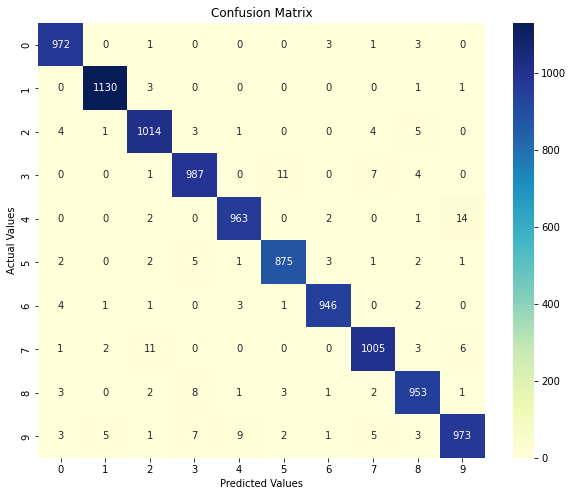

In [6]:
prototype_1.create_confusion_matrix()

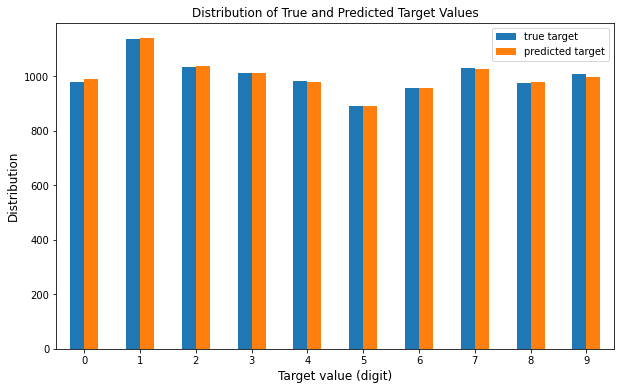

In [7]:
prototype_1.create_distribution_graphs()

In [8]:
prototype_2 = prototype(X_train_keras, X_test_keras, model_number=2)

Trial 3 Complete [00h 00m 08s]
val_accuracy: 0.9772499799728394

Best val_accuracy So Far: 0.9772499799728394
Total elapsed time: 00h 00m 30s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2329 - accuracy: 0.9305 - val_loss: 0.0960 - val_accuracy: 0.9712
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0917 - accuracy: 0.9714 - val_loss: 0.0748 - val_accuracy: 0.9778
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0634 - accuracy: 0.9796 - val_loss: 0.0601 - val_accuracy: 0.9843
Epoch 4/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0497 - accuracy: 0.9839 - val_loss: 0.0694 - val_accuracy: 0.9797
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0399 - accuracy: 0.9863 - val_loss: 0.0784 - val_accuracy: 0.9785
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0309 - accuracy: 0.989

1500/1500 [==============================] - 3s 2ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.0645 - val_accuracy: 0.9831
Epoch 7/29
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0258 - accuracy: 0.9913 - val_loss: 0.0810 - val_accuracy: 0.9811
Epoch 8/29
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.0689 - val_accuracy: 0.9835
Epoch 9/29
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0710 - val_accuracy: 0.9845
Epoch 10/29
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.0719 - val_accuracy: 0.9846
Epoch 11/29
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0172 - accuracy: 0.9937 - val_loss: 0.0730 - val_accuracy: 0.9844
Epoch 12/29
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0747 - val_accuracy: 0.9846


In [9]:
metrics_dict['Model 2'] = prototype_2.get_predictions()

In [10]:
prototype_2.get_classification_report()

              precision    recall  f1-score   support

           0     0.9898    0.9867    0.9882       980
           1     0.9869    0.9938    0.9903      1135
           2     0.9788    0.9855    0.9821      1032
           3     0.9682    0.9950    0.9814      1010
           4     0.9828    0.9898    0.9863       982
           5     0.9843    0.9865    0.9854       892
           6     0.9874    0.9843    0.9859       958
           7     0.9795    0.9757    0.9776      1028
           8     0.9957    0.9620    0.9786       974
           9     0.9840    0.9752    0.9796      1009

    accuracy                         0.9836     10000
   macro avg     0.9838    0.9835    0.9836     10000
weighted avg     0.9837    0.9836    0.9836     10000



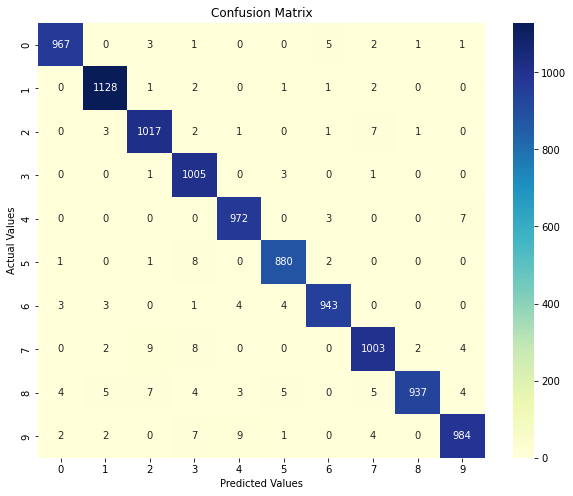

In [11]:
prototype_2.create_confusion_matrix()

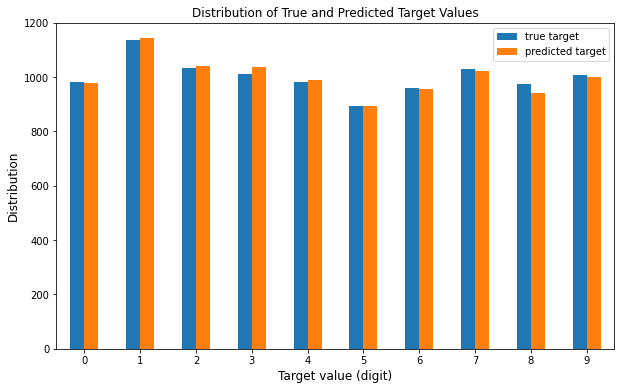

In [12]:
prototype_2.create_distribution_graphs()

In [13]:
prototype_3 = prototype(X_train_keras, X_test_keras, model_number=3)

Trial 3 Complete [00h 00m 48s]
val_accuracy: 0.10599999874830246

Best val_accuracy So Far: 0.984250009059906
Total elapsed time: 00h 02m 29s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.3603 - accuracy: 0.8734 - val_loss: 0.0793 - val_accuracy: 0.9764
Epoch 2/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0572 - accuracy: 0.9826 - val_loss: 0.0452 - val_accuracy: 0.9871
Epoch 3/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0421 - accuracy: 0.9879 - val_loss: 0.0399 - val_accuracy: 0.9883
Epoch 4/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0339 - accuracy: 0.9897 - val_loss: 0.0278 - val_accuracy: 0.9916
Epoch 5/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.0280 - val_accuracy: 0.9919
Epoch 6/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0241 - acc

In [14]:
metrics_dict['Model 3'] = prototype_3.get_predictions()

In [15]:
prototype_3.get_classification_report()

              precision    recall  f1-score   support

           0     0.9909    0.9990    0.9949       980
           1     0.9913    0.9991    0.9952      1135
           2     0.9980    0.9835    0.9907      1032
           3     0.9902    0.9980    0.9941      1010
           4     0.9939    0.9969    0.9954       982
           5     0.9955    0.9910    0.9933       892
           6     0.9937    0.9916    0.9927       958
           7     0.9951    0.9922    0.9937      1028
           8     0.9898    0.9959    0.9928       974
           9     0.9970    0.9871    0.9920      1009

    accuracy                         0.9935     10000
   macro avg     0.9935    0.9934    0.9935     10000
weighted avg     0.9935    0.9935    0.9935     10000



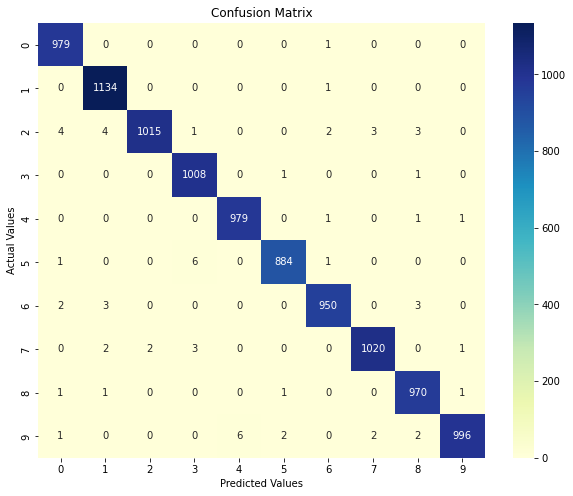

In [16]:
prototype_3.create_confusion_matrix()

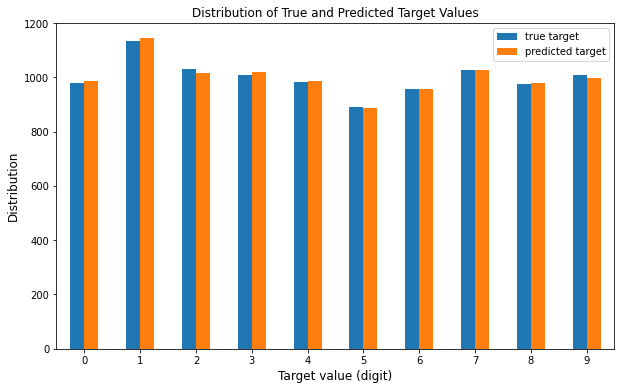

In [17]:
prototype_3.create_distribution_graphs()

In [18]:
prototype_4 = prototype(X_train_keras, X_test_keras, model_number=4)

Trial 3 Complete [00h 00m 11s]
val_accuracy: 0.9422500133514404

Best val_accuracy So Far: 0.9769166707992554
Total elapsed time: 00h 00m 36s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3117 - accuracy: 0.9028 - val_loss: 0.1157 - val_accuracy: 0.9645
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1210 - accuracy: 0.9613 - val_loss: 0.0906 - val_accuracy: 0.9703
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0927 - accuracy: 0.9704 - val_loss: 0.0638 - val_accuracy: 0.9808
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0765 - accuracy: 0.9753 - val_loss: 0.0614 - val_accuracy: 0.9818
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0635 - accuracy: 0.9794 - val_loss: 0.0514 - val_accuracy: 0.9847
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0585 - accuracy: 0.980

1500/1500 [==============================] - 5s 3ms/step - loss: 0.0533 - accuracy: 0.9827 - val_loss: 0.0534 - val_accuracy: 0.9839
Epoch 7/34
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0464 - accuracy: 0.9846 - val_loss: 0.0528 - val_accuracy: 0.9850
Epoch 8/34
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0423 - accuracy: 0.9866 - val_loss: 0.0475 - val_accuracy: 0.9870
Epoch 9/34
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0389 - accuracy: 0.9868 - val_loss: 0.0571 - val_accuracy: 0.9833
Epoch 10/34
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0352 - accuracy: 0.9884 - val_loss: 0.0518 - val_accuracy: 0.9859
Epoch 11/34
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0329 - accuracy: 0.9886 - val_loss: 0.0525 - val_accuracy: 0.9849
Epoch 12/34
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.0580 - val_accuracy: 0.9839


In [19]:
metrics_dict['Model 4'] = prototype_4.get_predictions()

In [20]:
prototype_4.get_classification_report()

              precision    recall  f1-score   support

           0     0.9829    0.9990    0.9909       980
           1     0.9939    0.9974    0.9956      1135
           2     0.9856    0.9961    0.9908      1032
           3     0.9881    0.9901    0.9891      1010
           4     0.9928    0.9898    0.9913       982
           5     0.9899    0.9877    0.9888       892
           6     0.9979    0.9854    0.9916       958
           7     0.9902    0.9844    0.9873      1028
           8     0.9856    0.9856    0.9856       974
           9     0.9900    0.9802    0.9851      1009

    accuracy                         0.9897     10000
   macro avg     0.9897    0.9896    0.9896     10000
weighted avg     0.9897    0.9897    0.9897     10000



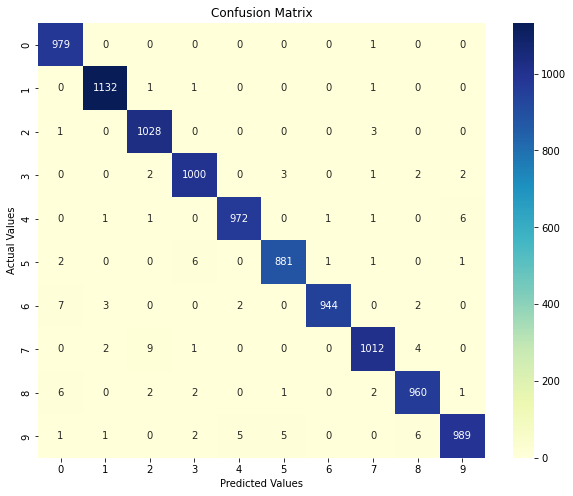

In [21]:
prototype_4.create_confusion_matrix()

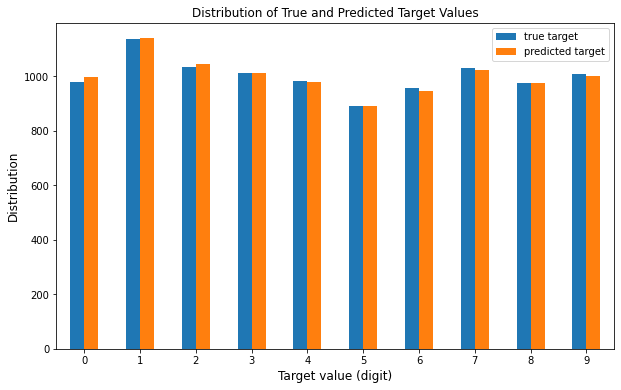

In [22]:
prototype_4.create_distribution_graphs()

In [23]:
create_metrics_csv(metrics_dict)

In [24]:
# Please refer to findings report for the analysis and comparison of the different prototypes implemented.